# Main Goals

We will explore how hard it is to find the best balance between the True Positive Rate TPR and the Fasle Positive Rate FPR. 

We will then turn to applying multi-class classifiers over the well known MNIST digits database, and analyse the results using a confusion matrix.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression

# Balancing TPR and FPR and interpretability of a classifier results given inbalance between classes

After your yearly checkup, the doctor has bad news and good news. The bad news is that you tested positive for a serious disease, and that the test is 99% accurate (i.e. the probability of testing positive given that you have the disease is 0.99, as is the probability of testing negative given that you don’t have the disease). The good news is that this is a rare disease, striking only 1 in 10,000 people. 

3 questions are interesting:

1. What are the TPR and FPR of the chosen classifier in this case? Giving that there is a balance between the two --- is it a good point on the ROC curve? 

2. Why is it good news that the disease is rare? What are the chances that you actually have the disease?

3. Taking into account the previous answers, would we say the designer of the classifier made a good choice in this case?

## Answer 1
From the instructions, we define the following events:
1. S: Sick
2. H: Healthy
3. Tp : Test positif
4. Tn : Test negatif

And the followings probabilitites
1. P(Tp|S) = 0.99
2. P(Tn|H) = 0.99
3. P(S) = 0.0001
4. P(H) = 1-P(S) = 0.9999

In this classification, we wish to predict if someone is sick or healthy according to a medical test.
In this case we define the TPR and FPR following:
* TPR = TP/(TP+FN) as P(Tp|S) = 0.99 (sensitivity given)
* FPR = FP/(FP+TN) as P(Tp|H)

Moreover, we can denote that the specificity is defines as:
* TNR = TN/(TN+FP) as P(Tn|H) = 0.99 (specificity given)

If the TPR and FPR are balanced, it leads to a impossible choice. In this case we wish to reduce the FPR and increase the TPR to predict the sickes among all positive tests. So the ROC curve should raise fastly.

## Answer 2

Because of the disease is rare, the TPR = P(Tp|S) = P(Tp and S)/P(S) should be increase as far as the medical test is accurate.

The chance to have the disease is:

P(S|Tp) = P(S)P(Tp|S)/P(Tp) 

With 
P(Tp) = P(S)P(Tp|S) + P(H)P(Tp|H) 

And P(Tp|H) is the FPR, it can calculat as FPR = 1 - TNR = 1 - P(Tn|H) = 0.01

So
P(S|Tp) = 0.0098

The patient has 0.98% to be sick if the test is positif.

## Answer 3
The previous result show that the test is not significant if the aim is to find sick people. However the choice of TPR and FPR permit to find each healthy people because P(H/Tn) = 99.97% and it minimize the false negatives.

# Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model) and Multivariate Logistic Regression (a discriminative model). 

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, each image faltten to create a 1D array with 784 elements.

## Loading the MNIST dataset

We load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 

 Each image is already transformed into a 1D integer array $x\in [0,255]^{64}$, and the corresponding label is an integer $y\in [0,9]$.

We plot a single sample of each digit as the original image, so we get a feeling how the data looks like.

Finally, we divide our data into train and test sets, using 1/7 of the data for testing.

---
**Note:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this study. Feel free to test the proformance of the algorithms below on the preprocessed data as well.


### loading MINST dataset

In [13]:
mnist = load_digits()

In [14]:
X = mnist.data
y = mnist.target

#### plot a sample

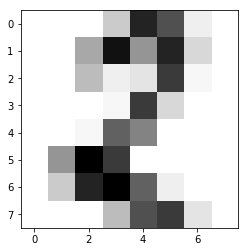

In [19]:
plt.imshow(X[50].reshape(8, 8), cmap='Greys')

#### split into train and test sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

## Bernoulli Naive Bayes

If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixel is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows for $$ x \in \{0,1\}^{64} $$
$$
\begin{cases}
\pi_j = \Pr(y=j) \\
P_j(x) = \Pr(x | y=j) \\
\end{cases}
$$

Where for each $i\in 0\ldots 64$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$

We write the classification rule based on this Naive Bayes model and how we esitmate each of the parameters of the model based on the trainning data.
We know from the Bayes Theorem that : $$ P(y=j|X) = \frac{P(y=j)P(X|y=j)}{P(X)} $$
We wish to determine the quantity $P(y=j|X)$ named as "posterior" and the naive Bayes methode implies that the term named as the "likelihood", $P(X|y=j)$, can be modify. In fact the assumption the naive Bayes methode is that the values of the vector $X$ are independent so:

$$ P(X|y=j) = \Pi P(x_i|y=j) $$

At this part we assume that the lkelihood follows a Bermoulli law of the pramater $p_{ji}$ which can be calculated thanks to the crosstab of the train set.

Moreover, the terms "prior, $P(y=j)$, is define as an equiprobability of the integers from 0 to 9 and "evidence", $P(X)$ is equal to one.

We obtain after calculation:
$$ P(y=j|X) = p_{ji}^{(\sum_{i=1}^nx_i)}(1-p_{ji})^{(n-\sum_{i=1}^nx_i)}  ,\quad x_1, \cdots, x_n \in \lbrace 0,\ 1\rbrace. $$

To predict the integer, we execute this calculus for each integer for the same vector and take the greatest.

Remark: looking on the data, we see that the edges of each pictures is a problem because it supposed that the number of zero is greater than the number of one, the data set is unbalanced. Too much zeros brings no information, in fact if one line contains only zero she could be linked to any value of classe (equiprobability). To manage this issue we may, during the preprocessing, retrieve zeros useless.
Algorithm suggested:

For each vector of train set we count 8 by 8 elements and if the sum of them is equal to zero, means that there is only zeros in this part of 64 elements.
We have to take care of new size of each vectors after modification. If there are not the same size whe should modify the model, precisely on how we estimate parameter of the Bernoulli parameter on the crosstab. To do that, after each modification we calculate the parameter thanks to the new number of elements.


### Run Naive Bayes Classifier
We run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, we use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. We plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remeber, we can do this since this is a generative model). We will need to access the `feature_log_prob_` attibute of the trained model.

2. We plot the confusion matrix of our classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images).

3. We think of a way to find the optimal threshold of the binarization part.


###  Run the Bernoulli Naive Bayes method

In [21]:
model = BernoulliNB(binarize=0.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Plot the mean image  and sample of each classes

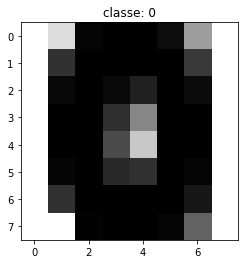

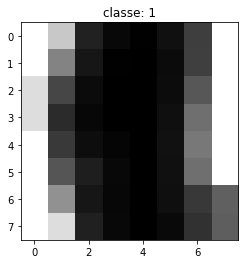

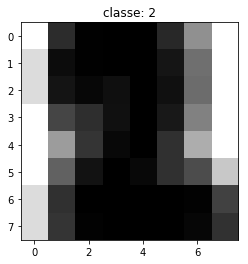

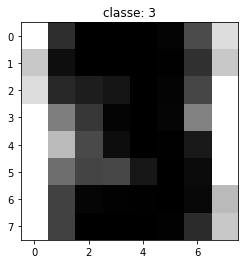

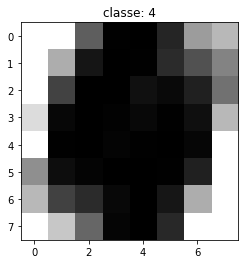

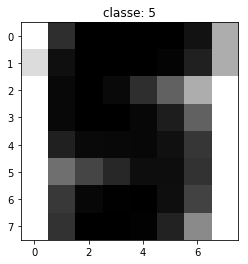

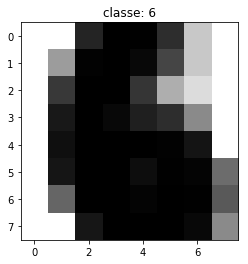

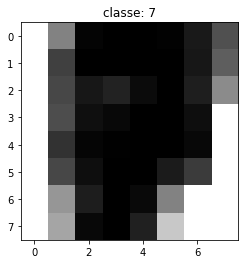

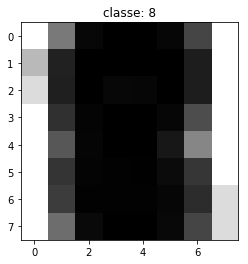

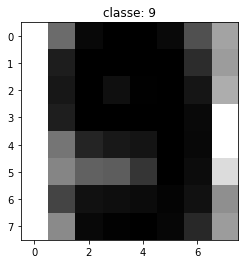

In [24]:
for i in range(model.feature_log_prob_.shape[0]):
    vector = model.feature_log_prob_[i]
    plt.imshow(vector.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('classe: %i' % i)
    plt.show()

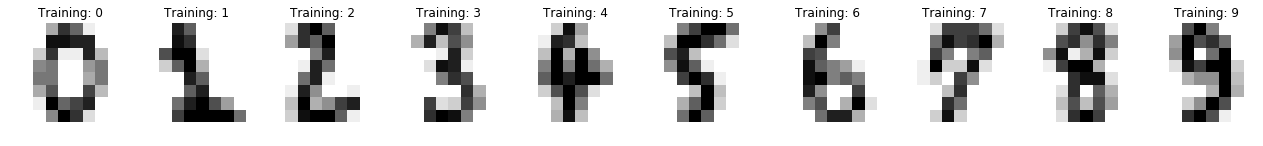

In [26]:
images_and_labels = list(zip(X_test, y_test))
ind = []
for i in range(10):
    ind.append(np.where(y_test==i)[0][0])

for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.axis('off')
    plt.imshow(X_test[ind[i]].reshape(8, -1), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % y_test[ind[i]])
plt.subplots_adjust(right=3)
plt.show()

### Plot the Confusion Matrix

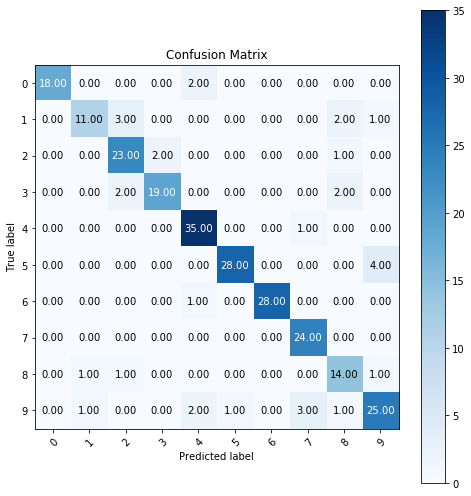

In [31]:
# define confusion matrix
cm = confusion_matrix(y_test, y_pred)
# define name of classes
classes = unique_labels(y_test, y_pred)
# define the plot of the confusion matrix
cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

### Print the report of the classifier

In [11]:
print("Classification report for classifier %s:\n%s\n" %(model, classification_report(y_test, y_pred)))

Classification report for classifier BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True):
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       982
         1.0       0.88      0.96      0.92      1124
         2.0       0.87      0.83      0.85       999
         3.0       0.75      0.80      0.78      1008
         4.0       0.83      0.81      0.82       928
         5.0       0.82      0.70      0.75       919
         6.0       0.90      0.90      0.90      1032
         7.0       0.93      0.84      0.88      1069
         8.0       0.76      0.77      0.76       986
         9.0       0.71      0.79      0.75       953

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000




The total accuracy of the BernoulliNB classifier is 83% which is pretty good.
However we see that the classes 9, 8 and 3 have a precision less than 80% and the classes 5, 8 and 9 have a recall less than 80%.
Thats means certain predictions are mistaken for the classes 3, 5, 8 and 9.

### A way to find the best threshold

To find the best threshold, the first idea is to run several BernoulliNB models with a different binarize attribute and choose the one with the best accuracy. Is like to perform the ROC curve.

## Multivariate Logistic Regression
We will now look at a discriminative model for this problem, specifically, the Multivariate Logistic Regression model.

In this part we will keep the pixel values in grayscale, and assume the probability of each image being classified as one of the 10 digit classes, matches some multivariate logistic function.

We run a Multivariate Logitic Regression classifier on the training data and apply predictions on the test data. Use the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation, and set the `solver` to be `'lbfgs'`.

1. As we did for the Naive Bayes classifier above, we plot the confusion matrix of our classifier, as claculated on the test data, and calculate the total accuracy. We summarize the results.

2. We show some test images which were missclassified. Choose one such sample, and output the probability estimates for all classes (use the `predict_proba` function).


### Predictions and Confusion Matrix results

In [37]:
model = LogisticRegression(solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/home/elbaz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


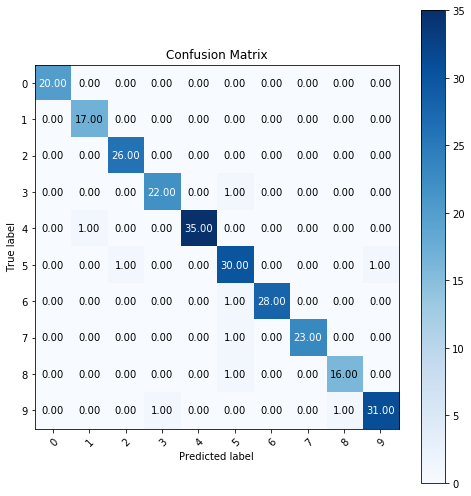

In [33]:
# define confusion matrix
cm = confusion_matrix(y_test, y_pred)
# define name of classes
classes = unique_labels(y_test, y_pred)
# define the plot of the confusion matrix
cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [38]:
print("Classification report for classifier %s:\n%s\n" %(model, classification_report(y_test, y_pred)))

Classification report for classifier LogisticRegression(max_iter=500):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.94      1.00      0.97        17
           2       1.00      1.00      1.00        26
           3       0.96      0.96      0.96        23
           4       1.00      0.97      0.99        36
           5       0.89      0.97      0.93        32
           6       1.00      0.97      0.98        29
           7       1.00      0.96      0.98        24
           8       0.94      0.94      0.94        17
           9       0.97      0.94      0.95        33

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257




Here we got an accuracy of 97% which is more better than the BernoulliNB model. This is due to the fact that the logistic regression applies on a set of continuous features and can take the data without preprocessing.
However we see again that the most difficult classes to predict are: 3, 5, 8 and 9.

### Missclassified image

In [39]:
# find and choose several index of missclassified image
ind_miss = []
for i in range(len(y_test)):
    if y_pred[i] != y_test[i]:
        ind_miss.append(i)
ind_miss = ind_miss[:5] 
ind_miss

[52, 133, 149, 159, 222]

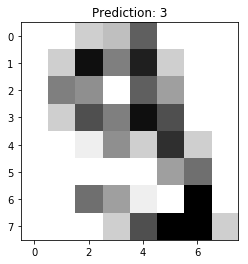

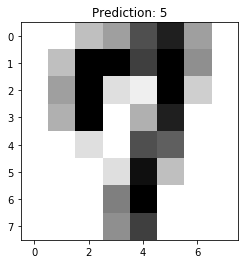

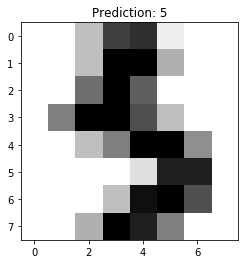

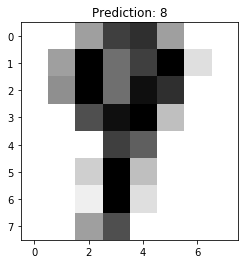

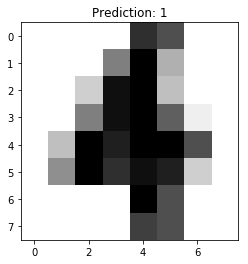

In [41]:
# plot image xith wrong prediction
images_and_predictions = list(zip(X_test[ind_miss], y_pred[ind_miss]))
for index, (image, prediction) in enumerate(images_and_predictions):
    plt.imshow(image.reshape(8,-1), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)
    plt.show()